In [1]:
import numpy as np
import pandas as pd
import re
import nltk.data
import sys
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import NMF
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

In [2]:
def preProcess(konten, judul):
    
#Sentence Segmentation & Case Folding
    a = konten
    a = a.replace(', ',',')
    a = a.replace(',',', ')
    teks = a.split(' ', 3)[3]
    teks = teks.replace('www.','')
    teks = teks.replace('.com','com')
    teks = teks.replace('.COM','COM')
    teks = teks.replace('.','. ')
    teks = teks.encode("ascii", "ignore")
    teks = teks.decode("ascii")
    teks = teks.replace('\n','')
    
    #Sentence Segmentation
    import nltk.data
    tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')
    kalimat = tokenizer.tokenize(teks)
    
    #Case Folding
    low = []
    for x in kalimat:
        a = re.sub(r'[^a-zA-Z0-9\s]', ' ', x)
        a = ''.join([i for i in a if not i.isdigit()])
        a = a.lower()
        low.append(a)
    
    
#Stopword removal
    from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
    factory = StopWordRemoverFactory()
    stopword = factory.create_stop_word_remover()
    
    stopped = []
    for s in low:
        stop = stopword.remove(s)
        stopped.append(stop)

    nyoba = pd.DataFrame({'col':stopped})
    
#Stemming
    from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
    factory1 = StemmerFactory()
    stemmer = factory1.create_stemmer()

    nyoba['col'] = nyoba['col'].apply(lambda x: stemmer.stem(x))
    stemmed = nyoba['col'].tolist()
    
    #Buat Dictionary untuk teks sebelum & setelah dilakukan preprocess (Belum tokenize)
    dictionary = dict(zip(stemmed, kalimat))
    
#Preprocess buat judul
    b = judul
    b = b.encode("ascii", "ignore")
    b = b.decode("ascii")
    b = b.replace('\n','')
    b = re.sub(r'[^a-zA-Z0-9\s]', ' ', b)
    b = ''.join([i for i in b if not i.isdigit()])
    b = b.lower()
    b = stopword.remove(b)
    b = stemmer.stem(b)
    
    #Buat Dictionary untuk teks sebelum & setelah dilakukan preprocess (Belum tokenize)
    dictionary = dict(zip(stemmed, kalimat))
    
    return dictionary, b

In [3]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import NMF

def kataKunci(kalimat, judul) :
    
    a = len(judul.split())
    
    vectorizer = CountVectorizer()
    
    X = vectorizer.fit_transform(kalimat)
    idx_to_word = np.array(vectorizer.get_feature_names())
    
    nmf = NMF(n_components=1, solver="mu", init = "random",
              beta_loss="frobenius", tol=1e-4) 
    W = nmf.fit_transform(X)
    H = nmf.components_
    
    for i, topic in enumerate(H) :
        keyword = idx_to_word[topic.argsort()[-a:]]
    
    keyword = keyword.tolist()
    katakunci = ' '.join(keyword)
    
    return katakunci

In [4]:
import numpy as np

def cosineSim(a,b) :
    dot_product = np.dot(a, b)
    norm_a = np.linalg.norm(a)
    norm_b = np.linalg.norm(b)
    return dot_product / (norm_a * norm_b)

In [5]:
def bestSentence(sentences, query):
    best_sentence = None
    maxVal = float("-inf")
    
    for sent in sentences:
        kalimat = []
        kalimat.append(sent)
        kalimat.append(query)
        
        vectorizer = CountVectorizer()
        tf = vectorizer.fit_transform(kalimat)
        tf = tf.toarray()
        tf_sent = tf[0]
        tf_query = tf[1]
        
        similarity = cosineSim(tf_sent, tf_query)
        
        if similarity > maxVal:
            best_sentence = sent
            maxVal = similarity
    
    sentences.remove(best_sentence)
    return best_sentence

In [6]:
def MMR(Si, query, Sj, lamda):
    
    kalimat = []
    kalimat.append(Si)
    kalimat.append(query)
        
    vectorizer = CountVectorizer()
    tf = vectorizer.fit_transform(kalimat)
    tf = tf.toarray()
    tf_Si = tf[0]
    tf_query = tf[1]
    
    Sim1 = cosineSim(tf_Si, tf_query)
    l_expr = lamda * Sim1
    value = []

    for sent in Sj:
        kalimat1 = []
        kalimat1.append(Si)
        kalimat1.append(sent)
        
        vectorizer = CountVectorizer()
        tf = vectorizer.fit_transform(kalimat1)
        tf = tf.toarray()
        tf_Si = tf[0]
        tf_sent = tf[1]
        
        Sim2 = cosineSim(tf_Si, tf_sent)
        value.append(Sim2)

    r_expr = (1-lamda) * max(value)
    MMR_SCORE = l_expr - r_expr

    return MMR_SCORE    

In [7]:
def makeSummary(sentences, best_sentence, query, summary_length, lamda):
    rangkuman = [best_sentence]
    sum_len = len(rangkuman)
    
    while sum_len < summary_length :
        MMRval = {}
        
        for sent in sentences:
            MMRval[sent] = MMR(sent, query, rangkuman, lamda)
        
        maxmmr = max(MMRval, key=MMRval.get)
        rangkuman.append(maxmmr)
        sentences.remove(maxmmr)
        sum_len = len(rangkuman)
    
    return rangkuman

In [8]:
def gabung(rangkuman, dictionary):
    summ_arr = []
    for summ in rangkuman :
        summ_arr.append(dictionary[summ])

    summary = ' '.join(summ_arr)
    
    return summary

In [9]:
def ngrams(s, n):
    s = s.lower()

    # Replace all none alphanumeric characters with spaces
    s = re.sub(r'[^a-zA-Z0-9\s]', ' ', s)

    # Break sentence in the token, remove empty tokens
    tokens = s.split(" ")

    token = []
    for tkn in tokens :
        if tkn != "":
            token.append(tkn)

    sequences = [token[i:] for i in range(n)]

    ngrams = zip(*sequences)
    
    ngram = []
    for i in ngrams:
        a = " ".join(i) 
        ngram.append(a)
    
    n_gram = set(ngram)
    return n_gram

In [10]:
def ROUGEN(manusia, sistem, n):
    #lowercase
    manusia = manusia.lower()
    sistem = sistem.lower()
    
    #stopword removal
    from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
    factory = StopWordRemoverFactory()
    stopword = factory.create_stop_word_remover()
    
    manusia = stopword.remove(manusia)
    manusia = re.sub(r'[^a-zA-Z0-9\s]', ' ', manusia)
    sistem = stopword.remove(sistem)
    sistem = re.sub(r'[^a-zA-Z0-9\s]', ' ', sistem)
    
    #stemming
    factory1 = StemmerFactory()
    stemmer = factory1.create_stemmer()
    manusia = stemmer.stem(manusia)
    sistem = stemmer.stem(sistem)
    
    #ngram
    ngramManusia = ngrams(manusia, n)
    ngramSistem = ngrams(sistem, n)
    
    a = len(ngramManusia)
    b = len(ngramSistem)
    c = 0
    
    for i in ngramSistem :
        d = 0
        for j in ngramManusia :
            if i==j:
                d = 1
        c = c+d
           
    r = c/a
    p = c/b
    
    if r+p > 0:
        f = 2*((r*p)/(r+p))
    else :
        f = 0
    
    return r,p,f

# Main Function
## Summarizing

In [12]:
berita = pd.read_csv("datasets/krjogjacom-berita.csv", engine='python', sep=';')
data = pd.read_csv("datasets/krjogjacom-rangkuman.csv", engine='python', sep=';')

In [13]:
kenny = data['manusia1'].tolist()
ale = data['manusia2'].tolist()
thovan = data['manusia3'].tolist()
guru1 = data['manusia4'].tolist()
guru2 = data['manusia5'].tolist()
guru3 = data['manusia6'].tolist()

In [14]:
df = berita[['title','content']]

In [15]:
judulBerita = []
queryJudul = []
queryNMF = []

rangkumanJudul = []
rangkumanNMF = []
rangkumanManual = []

for i in df.values:
    judul = i[0]
    konten = i[1]
    dictionary, title = preProcess(konten, judul) #preprocessing isi dan judul berita
    
    #mengambil teks berita dari dictionary
    teks = []
    for key, value in dictionary.items():
        temp = key
        teks.append(temp)
    
    teks1 = teks.copy()
    kalimat = teks.copy()
    
    query = kataKunci(teks, title) #mengambil kata kunci dengan metode NMF
    
    
    dariNMF = bestSentence(teks, query) #mengambil kalimat terbaik dengan query NMF dan cosinesim
    darijudul = bestSentence(teks1, title) #mengambil kalimat terbaik dengan query berdasarkan judul dan cosinesim
    
    #mendapatkan kalimat dengan lamda 0.7 dan sebanyak 5 kalimat
    summary = makeSummary(teks, dariNMF, query, 5, 0.7) #mendapatkan n kalimat terbaik dengan MMR dan NMF
    summaryJudul = makeSummary(teks1, darijudul, title, 5, 0.7) #mendapatkan n kalimat terbaik dengan MMR
    
    hasil = gabung(summary, dictionary) #rangkuman hasil NMF dan MMR
    hasilJudul = gabung(summaryJudul, dictionary) #rangkuman hasil MMR dengan query berdasarkan judul
    
    #memasukkan semua value kedalam list
    judulBerita.append(judul)
    queryJudul.append(title)
    queryNMF.append(query)
    rangkumanJudul.append(hasilJudul)
    rangkumanNMF.append(hasil)
    
#membuat tabel
hasilRangkuman = pd.DataFrame(
    {'judulBerita' : judulBerita,
     'queryJudul' : queryJudul,
     'queryNMF' : queryNMF,
     'manusia1' : kenny,
     'manusia2' : ale,
     'manusia3' : thovan,
     'manusia4' : guru1,
     'manusia5' : guru2,
     'manusia6' : guru3,
     'rangkumanJudul' : rangkumanJudul,
     'rangkumanNMF' : rangkumanNMF
    })

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys


In [17]:
rangk = hasilRangkuman[['judulBerita', 'queryJudul', 'queryNMF', 'rangkumanJudul', 'rangkumanNMF']]
rangk

,judulBerita,queryJudul,queryNMF,rangkumanJudul,rangkumanNMF
0,Cak Cuk Beri Pelatihan Solusi Lokal Pelestaria...,cak cuk latih solusi lokal lestari benda cagar...,komunitas solusi latih masalah masyarakat caga...,Karena sebenarnya apa yang saya sampaikan dapa...,Permasalahan pelestarian cagar budaya harus me...
1,"Menapak Usia 22 Taahun, Melia Laundry Tanamkan...",tapak usia taahun melia laundry tanam sikap in...,rangkai hut diri karyawan acara sosial melia l...,"Seusai memotong tumpeng, Anna menyampaikan ung...","Sebelumnya, berbagai rangkaian acara diselengg..."
2,Layanan 4G LTE XL Axiata Makin Masuk ke Peloso...,layan lte xl axiata pelosok sumatra sulawesi,kota axiata xl lte utara layan kabupaten,PT XL Axiata Tbk (XL Axiata) terus melakukan p...,Hingga saat ini total ada 138 kota/kabupaten d...
3,"23 Maret, CongWayNdut Kolabarasi dengan Wayang...",maret congwayndut kolabarasi wayang hip hop,sukrakasih yogyakarta wayang muda paguyuban da...,"Kolaborasi Kocak, antara Keroncong Wayang Gen...",Paguyuban Dalang Muda Sukrakasih sendiri merup...
4,38 Mahasiswa Indonesia Ikuti Young Socioprene...,mahasiswa indonesia ikut young sociopreneurshi...,bidang didik kunjung kbri thailand indonesia,Sebanyak 38 mahasiswa se-Indonesia yang tergab...,"Menurut Ketua Rombongan, Aan Fajar Lestari SS ..."
5,"Perempuan Pekerja Seni Segera Daftar, Ada Hiba...",perempuan kerja seni daftar hibah rp miliar,juri seni media laku aktivis hibah perempuan,Sosialisasi tentang program hibah untuk peremp...,Seleksi permohonan hibah dilakukan oleh delapa...
6,Trafik 4G LTE XL Axiata Melonjak Hingga 300%,trafik lte xl axiata lonjak,capai tahun layan naik trafik,Trafik layanan data PT XL Axiata Tbk (XL Axiat...,Jika dibandingkan dengan periode yang sama pad...
7,Fosipa Salurkan Bantuan Korban 'Cempaka',fosipa salur bantu korban cempaka,insan korban pariwisata fosipa bantu,Forum Silahturahmi Insan Pariwisata (Fosipa) m...,Forum Silahturahmi Insan Pariwisata (Fosipa) m...
8,"Film, Literasi, dan Tantangan Remaja Jadi Baha...",film literasi tantang remaja bahas ffpj,gera dosen ilmu komunikasi sosial pemuda,"Hal tersebut menjadi perhatian FFPJ kali ini, ...",Peran pemuda diperlukan untuk inisiator perger...
9,"Malam Ini 7 Desember, Bincang 'Layanan Perban...",malam desember bincang layan perban zaman now kr,widyo suprayogi layan wakil indonesia kepala b...,Mandiri Yogyakarta bekerja sama dengan KRJogja...,"Koordinator Acara Widyo Suprayogi mengatakan, ..."


## Evaluation

### ROUGE-1

In [18]:
recall_1 = []
precision_1 = []
fmeasure_1 = []

recall_nmf_1 = []
precision_nmf_1 = []
fmeasure_nmf_1 = []

#### Manusia 1

In [19]:
evl = hasilRangkuman[['manusia1','rangkumanJudul', 'rangkumanNMF']]

rec = []
prec = []
fs = []

rec_nmf = []
prec_nmf = []
fs_nmf = []

for i in evl.values:
    manusia = i[0]
    judul = i[1]
    nmf = i[2]
    
    r1, p1, f1 = ROUGEN(manusia, judul, 1)
    r1_nmf, p1_nmf, f1_nmf = ROUGEN(manusia, nmf, 1)
    
    rec.append(r1)
    prec.append(p1)
    fs.append(f1)
    
    rec_nmf.append(r1_nmf)
    prec_nmf.append(p1_nmf)
    fs_nmf.append(f1_nmf)    

r_k1 = sum(rec)/len(rec)
p_k1 = sum(prec)/len(prec)
f_k1 = sum(fs)/len(fs)

r_k1_nmf = sum(rec_nmf)/len(rec_nmf)
p_k1_nmf = sum(prec_nmf)/len(prec_nmf)
f_k1_nmf = sum(fs_nmf)/len(fs_nmf)

recall_1.append(rec)
precision_1.append(prec)
fmeasure_1.append(fs)

recall_nmf_1.append(rec_nmf)
precision_nmf_1.append(prec_nmf)
fmeasure_nmf_1.append(fs_nmf)

#### Manusia 2

In [20]:
evl = hasilRangkuman[['manusia2','rangkumanJudul', 'rangkumanNMF']]

rec = []
prec = []
fs = []

rec_nmf = []
prec_nmf = []
fs_nmf = []

for i in evl.values:
    manusia = i[0]
    judul = i[1]
    nmf = i[2]
    
    r1, p1, f1 = ROUGEN(manusia, judul, 1)
    r1_nmf, p1_nmf, f1_nmf = ROUGEN(manusia, nmf, 1)
    
    rec.append(r1)
    prec.append(p1)
    fs.append(f1)
    
    rec_nmf.append(r1_nmf)
    prec_nmf.append(p1_nmf)
    fs_nmf.append(f1_nmf)    

r_a1 = sum(rec)/len(rec)
p_a1 = sum(prec)/len(prec)
f_a1 = sum(fs)/len(fs)

r_a1_nmf = sum(rec_nmf)/len(rec_nmf)
p_a1_nmf = sum(prec_nmf)/len(prec_nmf)
f_a1_nmf = sum(fs_nmf)/len(fs_nmf)

recall_1.append(rec)
precision_1.append(prec)
fmeasure_1.append(fs)

recall_nmf_1.append(rec_nmf)
precision_nmf_1.append(prec_nmf)
fmeasure_nmf_1.append(fs_nmf)

#### Manusia 3

In [21]:
evl = hasilRangkuman[['manusia3','rangkumanJudul', 'rangkumanNMF']]

rec = []
prec = []
fs = []

rec_nmf = []
prec_nmf = []
fs_nmf = []

for i in evl.values:
    manusia = i[0]
    judul = i[1]
    nmf = i[2]
    
    r1, p1, f1 = ROUGEN(manusia, judul, 1)
    r1_nmf, p1_nmf, f1_nmf = ROUGEN(manusia, nmf, 1)
    
    rec.append(r1)
    prec.append(p1)
    fs.append(f1)
    
    rec_nmf.append(r1_nmf)
    prec_nmf.append(p1_nmf)
    fs_nmf.append(f1_nmf)    

r_t1 = sum(rec)/len(rec)
p_t1 = sum(prec)/len(prec)
f_t1 = sum(fs)/len(fs)

r_t1_nmf = sum(rec_nmf)/len(rec_nmf)
p_t1_nmf = sum(prec_nmf)/len(prec_nmf)
f_t1_nmf = sum(fs_nmf)/len(fs_nmf)

recall_1.append(rec)
precision_1.append(prec)
fmeasure_1.append(fs)

recall_nmf_1.append(rec_nmf)
precision_nmf_1.append(prec_nmf)
fmeasure_nmf_1.append(fs_nmf)

#### Manusia 4

In [22]:
evl = hasilRangkuman[['manusia4','rangkumanJudul', 'rangkumanNMF']]

rec = []
prec = []
fs = []

rec_nmf = []
prec_nmf = []
fs_nmf = []

for i in evl.values:
    manusia = i[0]
    judul = i[1]
    nmf = i[2]
    
    r1, p1, f1 = ROUGEN(manusia, judul, 1)
    r1_nmf, p1_nmf, f1_nmf = ROUGEN(manusia, nmf, 1)
    
    rec.append(r1)
    prec.append(p1)
    fs.append(f1)
    
    rec_nmf.append(r1_nmf)
    prec_nmf.append(p1_nmf)
    fs_nmf.append(f1_nmf)    

r_g1 = sum(rec)/len(rec)
p_g1 = sum(prec)/len(prec)
f_g1 = sum(fs)/len(fs)

r_g1_nmf = sum(rec_nmf)/len(rec_nmf)
p_g1_nmf = sum(prec_nmf)/len(prec_nmf)
f_g1_nmf = sum(fs_nmf)/len(fs_nmf)

recall_1.append(rec)
precision_1.append(prec)
fmeasure_1.append(fs)

recall_nmf_1.append(rec_nmf)
precision_nmf_1.append(prec_nmf)
fmeasure_nmf_1.append(fs_nmf)

#### Manusia 5

In [23]:
evl = hasilRangkuman[['manusia5','rangkumanJudul', 'rangkumanNMF']]

rec = []
prec = []
fs = []

rec_nmf = []
prec_nmf = []
fs_nmf = []

for i in evl.values:
    manusia = i[0]
    judul = i[1]
    nmf = i[2]
    
    r1, p1, f1 = ROUGEN(manusia, judul, 1)
    r1_nmf, p1_nmf, f1_nmf = ROUGEN(manusia, nmf, 1)
    
    rec.append(r1)
    prec.append(p1)
    fs.append(f1)
    
    rec_nmf.append(r1_nmf)
    prec_nmf.append(p1_nmf)
    fs_nmf.append(f1_nmf)    

r_h1 = sum(rec)/len(rec)
p_h1 = sum(prec)/len(prec)
f_h1 = sum(fs)/len(fs)

r_h1_nmf = sum(rec_nmf)/len(rec_nmf)
p_h1_nmf = sum(prec_nmf)/len(prec_nmf)
f_h1_nmf = sum(fs_nmf)/len(fs_nmf)

recall_1.append(rec)
precision_1.append(prec)
fmeasure_1.append(fs)

recall_nmf_1.append(rec_nmf)
precision_nmf_1.append(prec_nmf)
fmeasure_nmf_1.append(fs_nmf)

#### Manusia 6

In [24]:
evl = hasilRangkuman[['manusia6','rangkumanJudul', 'rangkumanNMF']]

rec = []
prec = []
fs = []

rec_nmf = []
prec_nmf = []
fs_nmf = []

for i in evl.values:
    manusia = i[0]
    judul = i[1]
    nmf = i[2]
    
    r1, p1, f1 = ROUGEN(manusia, judul, 1)
    r1_nmf, p1_nmf, f1_nmf = ROUGEN(manusia, nmf, 1)
    
    rec.append(r1)
    prec.append(p1)
    fs.append(f1)
    
    rec_nmf.append(r1_nmf)
    prec_nmf.append(p1_nmf)
    fs_nmf.append(f1_nmf)    

r_i1 = sum(rec)/len(rec)
p_i1 = sum(prec)/len(prec)
f_i1 = sum(fs)/len(fs)

r_i1_nmf = sum(rec_nmf)/len(rec_nmf)
p_i1_nmf = sum(prec_nmf)/len(prec_nmf)
f_i1_nmf = sum(fs_nmf)/len(fs_nmf)

recall_1.append(rec)
precision_1.append(prec)
fmeasure_1.append(fs)

recall_nmf_1.append(rec_nmf)
precision_nmf_1.append(prec_nmf)
fmeasure_nmf_1.append(fs_nmf)

#### Rata-rata

In [25]:
r_1 = (r_k1+r_a1+r_t1+r_g1+r_h1+r_i1)/6
p_1 = (p_k1+p_a1+p_t1+p_g1+p_h1+p_i1)/6
f_1 = (f_k1+f_a1+f_t1+f_g1+f_h1+f_i1)/6

r_1_nmf = (r_k1_nmf+r_a1_nmf+r_t1_nmf+r_g1_nmf+r_h1_nmf+r_i1_nmf)/6
p_1_nmf = (p_k1_nmf+p_a1_nmf+p_t1_nmf+p_g1_nmf+p_h1_nmf+p_i1_nmf)/6
f_1_nmf = (f_k1_nmf+f_a1_nmf+f_t1_nmf+f_g1_nmf+f_h1_nmf+f_i1_nmf)/6

print('judul')
print(r_1, p_1, f_1)

print('nmf')
print(r_1_nmf, p_1_nmf, f_1_nmf)

judul
0.627039134111989 0.6958665929790208 0.6537952022869097
nmf
0.6715280611443978 0.6939402575944636 0.677285034883333


### ROUGE-2

In [26]:
recall_2 = []
precision_2 = []
fmeasure_2 = []

recall_nmf_2 = []
precision_nmf_2 = []
fmeasure_nmf_2 = []

#### Manusia 1

In [31]:
evl = hasilRangkuman[['manusia1','rangkumanJudul', 'rangkumanNMF']]

rec = []
prec = []
fs = []

rec_nmf = []
prec_nmf = []
fs_nmf = []

for i in evl.values:
    manusia = i[0]
    judul = i[1]
    nmf = i[2]
    
    r2, p2, f2 = ROUGEN(manusia, judul, 2)
    r2_nmf, p2_nmf, f2_nmf = ROUGEN(manusia, nmf, 2)
    
    rec.append(r2)
    prec.append(p2)
    fs.append(f2)
    
    rec_nmf.append(r2_nmf)
    prec_nmf.append(p2_nmf)
    fs_nmf.append(f2_nmf)    

r_k2 = sum(rec)/len(rec)
p_k2 = sum(prec)/len(prec)
f_k2 = sum(fs)/len(fs)

r_k2_nmf = sum(rec_nmf)/len(rec_nmf)
p_k2_nmf = sum(prec_nmf)/len(prec_nmf)
f_k2_nmf = sum(fs_nmf)/len(fs_nmf)

recall_2.append(rec)
precision_2.append(prec)
fmeasure_2.append(fs)

recall_nmf_2.append(rec_nmf)
precision_nmf_2.append(prec_nmf)
fmeasure_nmf_2.append(fs_nmf)

#### Manusia 2

In [32]:
evl = hasilRangkuman[['manusia2','rangkumanJudul', 'rangkumanNMF']]

rec = []
prec = []
fs = []

rec_nmf = []
prec_nmf = []
fs_nmf = []

for i in evl.values:
    manusia = i[0]
    judul = i[1]
    nmf = i[2]
    
    r2, p2, f2 = ROUGEN(manusia, judul, 2)
    r2_nmf, p2_nmf, f2_nmf = ROUGEN(manusia, nmf, 2)
    
    rec.append(r2)
    prec.append(p2)
    fs.append(f2)
    
    rec_nmf.append(r2_nmf)
    prec_nmf.append(p2_nmf)
    fs_nmf.append(f2_nmf)    

r_a2 = sum(rec)/len(rec)
p_a2 = sum(prec)/len(prec)
f_a2 = sum(fs)/len(fs)

r_a2_nmf = sum(rec_nmf)/len(rec_nmf)
p_a2_nmf = sum(prec_nmf)/len(prec_nmf)
f_a2_nmf = sum(fs_nmf)/len(fs_nmf)

recall_2.append(rec)
precision_2.append(prec)
fmeasure_2.append(fs)

recall_nmf_2.append(rec_nmf)
precision_nmf_2.append(prec_nmf)
fmeasure_nmf_2.append(fs_nmf)

#### Manusia 3

In [33]:
evl = hasilRangkuman[['manusia3','rangkumanJudul', 'rangkumanNMF']]

rec = []
prec = []
fs = []

rec_nmf = []
prec_nmf = []
fs_nmf = []

for i in evl.values:
    manusia = i[0]
    judul = i[1]
    nmf = i[2]
    
    r2, p2, f2 = ROUGEN(manusia, judul, 2)
    r2_nmf, p2_nmf, f2_nmf = ROUGEN(manusia, nmf, 2)
    
    rec.append(r2)
    prec.append(p2)
    fs.append(f2)
    
    rec_nmf.append(r2_nmf)
    prec_nmf.append(p2_nmf)
    fs_nmf.append(f2_nmf)    

r_t2 = sum(rec)/len(rec)
p_t2 = sum(prec)/len(prec)
f_t2 = sum(fs)/len(fs)

r_t2_nmf = sum(rec_nmf)/len(rec_nmf)
p_t2_nmf = sum(prec_nmf)/len(prec_nmf)
f_t2_nmf = sum(fs_nmf)/len(fs_nmf)

recall_2.append(rec)
precision_2.append(prec)
fmeasure_2.append(fs)

recall_nmf_2.append(rec_nmf)
precision_nmf_2.append(prec_nmf)
fmeasure_nmf_2.append(fs_nmf)

#### Manusia 4

In [34]:
evl = hasilRangkuman[['manusia4','rangkumanJudul', 'rangkumanNMF']]

rec = []
prec = []
fs = []

rec_nmf = []
prec_nmf = []
fs_nmf = []

for i in evl.values:
    manusia = i[0]
    judul = i[1]
    nmf = i[2]
    
    r2, p2, f2 = ROUGEN(manusia, judul, 2)
    r2_nmf, p2_nmf, f2_nmf = ROUGEN(manusia, nmf, 2)
    
    rec.append(r2)
    prec.append(p2)
    fs.append(f2)
    
    rec_nmf.append(r2_nmf)
    prec_nmf.append(p2_nmf)
    fs_nmf.append(f2_nmf)    

r_g2 = sum(rec)/len(rec)
p_g2 = sum(prec)/len(prec)
f_g2 = sum(fs)/len(fs)

r_g2_nmf = sum(rec_nmf)/len(rec_nmf)
p_g2_nmf = sum(prec_nmf)/len(prec_nmf)
f_g2_nmf = sum(fs_nmf)/len(fs_nmf)

recall_2.append(rec)
precision_2.append(prec)
fmeasure_2.append(fs)

recall_nmf_2.append(rec_nmf)
precision_nmf_2.append(prec_nmf)
fmeasure_nmf_2.append(fs_nmf)

#### Manusia 5

In [35]:
evl = hasilRangkuman[['manusia5','rangkumanJudul', 'rangkumanNMF']]

rec = []
prec = []
fs = []

rec_nmf = []
prec_nmf = []
fs_nmf = []

for i in evl.values:
    manusia = i[0]
    judul = i[1]
    nmf = i[2]
    
    r2, p2, f2 = ROUGEN(manusia, judul, 2)
    r2_nmf, p2_nmf, f2_nmf = ROUGEN(manusia, nmf, 2)
    
    rec.append(r2)
    prec.append(p2)
    fs.append(f2)
    
    rec_nmf.append(r2_nmf)
    prec_nmf.append(p2_nmf)
    fs_nmf.append(f2_nmf)    

r_h2 = sum(rec)/len(rec)
p_h2 = sum(prec)/len(prec)
f_h2 = sum(fs)/len(fs)

r_h2_nmf = sum(rec_nmf)/len(rec_nmf)
p_h2_nmf = sum(prec_nmf)/len(prec_nmf)
f_h2_nmf = sum(fs_nmf)/len(fs_nmf)

recall_2.append(rec)
precision_2.append(prec)
fmeasure_2.append(fs)

recall_nmf_2.append(rec_nmf)
precision_nmf_2.append(prec_nmf)
fmeasure_nmf_2.append(fs_nmf)

#### Manusia 6

In [36]:
evl = hasilRangkuman[['manusia6','rangkumanJudul', 'rangkumanNMF']]

rec = []
prec = []
fs = []

rec_nmf = []
prec_nmf = []
fs_nmf = []

for i in evl.values:
    manusia = i[0]
    judul = i[1]
    nmf = i[2]
    
    r2, p2, f2 = ROUGEN(manusia, judul, 2)
    r2_nmf, p2_nmf, f2_nmf = ROUGEN(manusia, nmf, 2)
    
    rec.append(r2)
    prec.append(p2)
    fs.append(f2)
    
    rec_nmf.append(r2_nmf)
    prec_nmf.append(p2_nmf)
    fs_nmf.append(f2_nmf)    

r_i2 = sum(rec)/len(rec)
p_i2 = sum(prec)/len(prec)
f_i2 = sum(fs)/len(fs)

r_i2_nmf = sum(rec_nmf)/len(rec_nmf)
p_i2_nmf = sum(prec_nmf)/len(prec_nmf)
f_i2_nmf = sum(fs_nmf)/len(fs_nmf)

recall_2.append(rec)
precision_2.append(prec)
fmeasure_2.append(fs)

recall_nmf_2.append(rec_nmf)
precision_nmf_2.append(prec_nmf)
fmeasure_nmf_2.append(fs_nmf)

#### Rata-rata

In [37]:
r_2 = (r_k2+r_a2+r_t2+r_g2+r_h2+r_i2)/6
p_2 = (p_k2+p_a2+p_t2+p_g2+p_h2+p_i2)/6
f_2 = (f_k2+f_a2+f_t2+f_g2+f_h2+f_i2)/6

r_2_nmf = (r_k2_nmf+r_a2_nmf+r_t2_nmf+r_g2_nmf+r_h2_nmf+r_i2_nmf)/6
p_2_nmf = (p_k2_nmf+p_a2_nmf+p_t2_nmf+p_g2_nmf+p_h2_nmf+p_i2_nmf)/6
f_2_nmf = (f_k2_nmf+f_a2_nmf+f_t2_nmf+f_g2_nmf+f_h2_nmf+f_i2_nmf)/6

print('judul')
print(r_2, p_2, f_2)

print('nmf')
print(r_2_nmf, p_2_nmf, f_2_nmf)

judul
0.5311455619994275 0.5860564804325036 0.5521236325567983
nmf
0.5850322489444343 0.5840477817377941 0.5804596971882057


## Evaluasi per Berita

In [38]:
pd.set_option('display.max_rows', 100)

### ROUGE-1

#### Judul

In [39]:
judul_r1 = pd.DataFrame(
    {'manusia1' : recall_1[0],
     'manusia2' : recall_1[1],
     'manusia3' : recall_1[2],
     'manusia4' : recall_1[3],
     'manusia5' : recall_1[4],
     'manusia6' : recall_1[5],
    })

judul_r1['mean'] = judul_r1.mean(axis=1)
rata_r1 = judul_r1['mean'].tolist()

judul_p1 = pd.DataFrame(
    {'manusia1' : precision_1[0],
     'manusia2' : precision_1[1],
     'manusia3' : precision_1[2],
     'manusia4' : precision_1[3],
     'manusia5' : precision_1[4],
     'manusia6' : precision_1[5],
    })

judul_p1['mean'] = judul_p1.mean(axis=1)
rata_p1 = judul_p1['mean'].tolist()

judul_f1 = pd.DataFrame(
    {'manusia1' : fmeasure_1[0],
     'manusia2' : fmeasure_1[1],
     'manusia3' : fmeasure_1[2],
     'manusia4' : fmeasure_1[3],
     'manusia5' : fmeasure_1[4],
     'manusia6' : fmeasure_1[5],
    })

judul_f1['mean'] = judul_f1.mean(axis=1)
rata_f1 = judul_f1['mean'].tolist()

judul1 = pd.DataFrame(
    {'recall' : rata_r1,
     'precision' : rata_p1,
     'fmeasure' : rata_f1,
    })

judul1_percent = judul1.style.format({
    'recall': '{:,.2%}'.format,
    'precision': '{:,.2%}'.format,
    'fmeasure': '{:,.2%}'.format,
})

judul1_percent

,recall,precision,fmeasure
0,57.89%,63.01%,60.10%
1,55.49%,55.47%,55.40%
2,54.80%,67.36%,60.26%
3,65.35%,75.00%,69.59%
4,69.19%,73.33%,71.14%
5,55.86%,81.35%,64.47%
6,49.11%,55.10%,51.86%
7,90.41%,95.83%,92.92%
8,26.53%,47.62%,33.96%
9,55.79%,72.59%,62.94%


#### NMF

In [40]:
nmf_r1 = pd.DataFrame(
    {'manusia1' : recall_nmf_1[0],
     'manusia2' : recall_nmf_1[1],
     'manusia3' : recall_nmf_1[2],
     'manusia4' : recall_nmf_1[3],
     'manusia5' : recall_nmf_1[4],
     'manusia6' : recall_nmf_1[5],
    })

nmf_r1['mean'] = nmf_r1.mean(axis=1)
ratanmf_r1 = nmf_r1['mean'].tolist()

nmf_p1 = pd.DataFrame(
    {'manusia1' : precision_nmf_1[0],
     'manusia2' : precision_nmf_1[1],
     'manusia3' : precision_nmf_1[2],
     'manusia4' : precision_nmf_1[3],
     'manusia5' : precision_nmf_1[4],
     'manusia6' : precision_nmf_1[5],
    })

nmf_p1['mean'] = nmf_p1.mean(axis=1)
ratanmf_p1 = nmf_p1['mean'].tolist()

nmf_f1 = pd.DataFrame(
    {'manusia1' : fmeasure_nmf_1[0],
     'manusia2' : fmeasure_nmf_1[1],
     'manusia3' : fmeasure_nmf_1[2],
     'manusia4' : fmeasure_nmf_1[3],
     'manusia5' : fmeasure_nmf_1[4],
     'manusia6' : fmeasure_nmf_1[5],
    })

nmf_f1['mean'] = nmf_f1.mean(axis=1)
ratanmf_f1 = nmf_f1['mean'].tolist()

nmf1 = pd.DataFrame(
    {'recall' : ratanmf_r1,
     'precision' : ratanmf_p1,
     'fmeasure' : ratanmf_f1,
    })

nmf1_percent = nmf1.style.format({
    'recall': '{:,.2%}'.format,
    'precision': '{:,.2%}'.format,
    'fmeasure': '{:,.2%}'.format,
})

nmf1_percent

,recall,precision,fmeasure
0,55.27%,78.12%,64.50%
1,64.98%,64.32%,64.55%
2,71.17%,73.10%,71.91%
3,86.39%,80.00%,82.81%
4,66.59%,73.98%,70.03%
5,77.64%,63.37%,68.33%
6,69.33%,59.64%,64.03%
7,92.01%,83.33%,87.33%
8,60.49%,64.44%,62.22%
9,80.53%,86.31%,83.19%


### ROUGE-2

#### Judul

In [41]:
judul_r2 = pd.DataFrame(
    {'manusia1' : recall_2[0],
     'manusia2' : recall_2[1],
     'manusia3' : recall_2[2],
     'manusia4' : recall_2[3],
     'manusia5' : recall_2[4],
     'manusia6' : recall_2[5],
    })

judul_r2['mean'] = judul_r2.mean(axis=1)
rata_r2 = judul_r2['mean'].tolist()

judul_p2 = pd.DataFrame(
    {'manusia1' : precision_2[0],
     'manusia2' : precision_2[1],
     'manusia3' : precision_2[2],
     'manusia4' : precision_2[3],
     'manusia5' : precision_2[4],
     'manusia6' : precision_2[5],
    })

judul_p2['mean'] = judul_p2.mean(axis=1)
rata_p2 = judul_p2['mean'].tolist()

judul_f2 = pd.DataFrame(
    {'manusia1' : fmeasure_2[0],
     'manusia2' : fmeasure_2[1],
     'manusia3' : fmeasure_2[2],
     'manusia4' : fmeasure_2[3],
     'manusia5' : fmeasure_2[4],
     'manusia6' : fmeasure_2[5],
    })

judul_f2['mean'] = judul_f2.mean(axis=1)
rata_f2 = judul_f2['mean'].tolist()

judul2 = pd.DataFrame(
    {'recall' : rata_r2,
     'precision' : rata_p2,
     'fmeasure' : rata_f2,
    })

judul2_percent = judul2.style.format({
    'recall': '{:,.2%}'.format,
    'precision': '{:,.2%}'.format,
    'fmeasure': '{:,.2%}'.format,
})

judul2_percent

,recall,precision,fmeasure
0,54.14%,58.49%,56.19%
1,49.56%,51.37%,50.41%
2,37.12%,48.01%,41.84%
3,57.42%,67.19%,61.88%
4,58.24%,61.43%,59.74%
5,62.03%,77.16%,67.59%
6,32.93%,43.65%,37.52%
7,87.14%,90.61%,88.76%
8,18.14%,34.15%,23.61%
9,42.11%,60.33%,49.60%


#### NMF

In [42]:
nmf_r2 = pd.DataFrame(
    {'manusia1' : recall_nmf_2[0],
     'manusia2' : recall_nmf_2[1],
     'manusia3' : recall_nmf_2[2],
     'manusia4' : recall_nmf_2[3],
     'manusia5' : recall_nmf_2[4],
     'manusia6' : recall_nmf_2[5],
    })

nmf_r2['mean'] = nmf_r2.mean(axis=1)
ratanmf_r2 = nmf_r2['mean'].tolist()

nmf_p2 = pd.DataFrame(
    {'manusia1' : precision_nmf_2[0],
     'manusia2' : precision_nmf_2[1],
     'manusia3' : precision_nmf_2[2],
     'manusia4' : precision_nmf_2[3],
     'manusia5' : precision_nmf_2[4],
     'manusia6' : precision_nmf_2[5],
    })

nmf_p2['mean'] = nmf_p2.mean(axis=1)
ratanmf_p2 = nmf_p2['mean'].tolist()

nmf_f2 = pd.DataFrame(
    {'manusia1' : fmeasure_nmf_2[0],
     'manusia2' : fmeasure_nmf_2[1],
     'manusia3' : fmeasure_nmf_2[2],
     'manusia4' : fmeasure_nmf_2[3],
     'manusia5' : fmeasure_nmf_2[4],
     'manusia6' : fmeasure_nmf_2[5],
    })

nmf_f2['mean'] = nmf_f2.mean(axis=1)
ratanmf_f2 = nmf_f2['mean'].tolist()

nmf2 = pd.DataFrame(
    {'recall' : ratanmf_r2,
     'precision' : ratanmf_p2,
     'fmeasure' : ratanmf_f2,
    })

nmf2_percent = nmf2.style.format({
    'recall': '{:,.2%}'.format,
    'precision': '{:,.2%}'.format,
    'fmeasure': '{:,.2%}'.format,
})

nmf2_percent

,recall,precision,fmeasure
0,52.64%,73.98%,61.47%
1,57.72%,57.11%,57.34%
2,67.21%,64.63%,65.86%
3,83.73%,79.75%,81.62%
4,61.76%,64.76%,63.18%
5,70.49%,49.38%,56.84%
6,56.81%,48.80%,52.46%
7,86.59%,79.63%,82.88%
8,55.06%,55.62%,55.24%
9,78.48%,83.83%,81.06%


## Evaluasi per Jenis Rangkuman

In [43]:
print('ROUGE-1 pada Rangkuman Query dari Judul')
print(r_1, p_1, f_1)

print('ROUGE-1 pada Rangkuman Query Hasil NMF')
print(r_1_nmf, p_1_nmf, f_1_nmf)

print('ROUGE-2 pada Rangkuman Query dari Judul')
print(r_2, p_2, f_2)

print('ROUGE-2 pada Rangkuman Query Hasil NMF')
print(r_2_nmf, p_2_nmf, f_2_nmf)

ROUGE-1 pada Rangkuman Query dari Judul
0.627039134111989 0.6958665929790208 0.6537952022869097
ROUGE-1 pada Rangkuman Query Hasil NMF
0.6715280611443978 0.6939402575944636 0.677285034883333
ROUGE-2 pada Rangkuman Query dari Judul
0.5311455619994275 0.5860564804325036 0.5521236325567983
ROUGE-2 pada Rangkuman Query Hasil NMF
0.5850322489444343 0.5840477817377941 0.5804596971882057


#### Rangkuman Query Judul

In [44]:
r_jdl = [r_1, r_2]
p_jdl = [p_1, p_2]
f_jdl = [f_1, f_2]
idx = ['ROUGE1', 'ROUGE2']

rouge_jdl = pd.DataFrame(
    {'pengujian' : idx,
     'recall' : r_jdl,
     'precision' : p_jdl,
     'f-measure' : f_jdl,
    })

rouge_jdl.set_index('pengujian', inplace=True)

rougejdl = rouge_jdl.style.format({
    'recall': '{:,.2%}'.format,
    'precision': '{:,.2%}'.format,
    'f-measure': '{:,.2%}'.format,
})

rougejdl

,recall,precision,f-measure
pengujian,,,
ROUGE1,62.70%,69.59%,65.38%
ROUGE2,53.11%,58.61%,55.21%


#### Rangkuman Query NMF

In [45]:
r_nmf = [r_1_nmf, r_2_nmf]
p_nmf = [p_1_nmf, p_2_nmf]
f_nmf = [f_1_nmf, f_2_nmf]
idx = ['ROUGE1', 'ROUGE2']

rouge_nmf = pd.DataFrame(
    {'pengujian' : idx,
     'recall' : r_nmf,
     'precision' : p_nmf,
     'f-measure' : f_nmf,
    })

rouge_nmf.set_index('pengujian', inplace=True)

rougenmf = rouge_nmf.style.format({
    'recall': '{:,.2%}'.format,
    'precision': '{:,.2%}'.format,
    'f-measure': '{:,.2%}'.format,
})

rougenmf

,recall,precision,f-measure
pengujian,,,
ROUGE1,67.15%,69.39%,67.73%
ROUGE2,58.50%,58.40%,58.05%


## Berdasarkan tipe pengujian

### ROUGE-1

In [46]:
idx = ['recall', 'precision', 'f-measure']
dok1 = [r_1, p_1, f_1]
dok2 = [r_1_nmf, p_1_nmf, f_1_nmf]

rg1 = pd.DataFrame(
    {'nilai' : idx,
     'judul' : dok1,
     'nmf' : dok2
    })

rg_1 = rg1.style.format({
    'nmf': '{:,.2%}'.format,
    'judul': '{:,.2%}'.format,
})

rg_1

,nilai,judul,nmf
0,recall,62.70%,67.15%
1,precision,69.59%,69.39%
2,f-measure,65.38%,67.73%


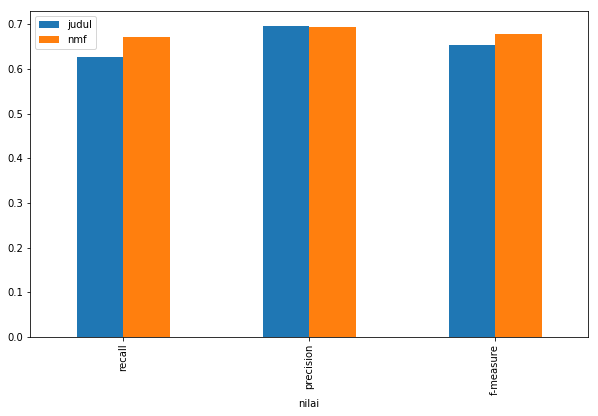

In [47]:
import matplotlib.pyplot as plt

ax = rg1.plot(x = 'nilai' , kind = 'bar', figsize = (10,6))

### ROUGE-2

In [48]:
idx = ['recall', 'precision', 'f-measure']
dok1 = [r_2, p_2, f_2]
dok2 = [r_2_nmf, p_2_nmf, f_2_nmf]

rg2 = pd.DataFrame(
    {'nilai' : idx,
     'judul' : dok1,
     'nmf' : dok2
    })

rg_2 = rg2.style.format({
    'nmf': '{:,.2%}'.format,
    'judul': '{:,.2%}'.format,
})

rg_2

,nilai,judul,nmf
0,recall,53.11%,58.50%
1,precision,58.61%,58.40%
2,f-measure,55.21%,58.05%


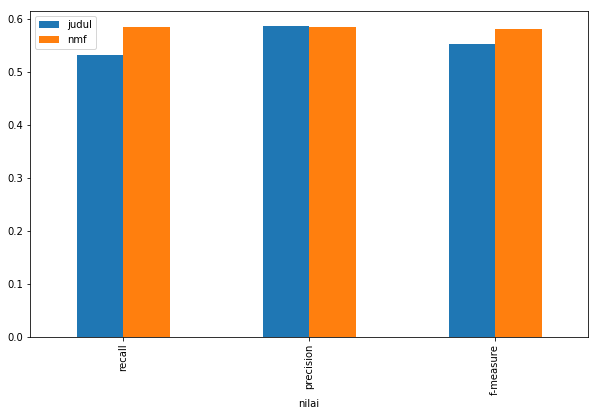

In [49]:
import matplotlib.pyplot as plt

ax = rg2.plot(x = 'nilai' , kind = 'bar', figsize = (10,6))